In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

# Задача классификации

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [4]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [02:52<00:00, 57.5kB/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 30.2kB/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:11<00:00, 139kB/s] 


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.28MB/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

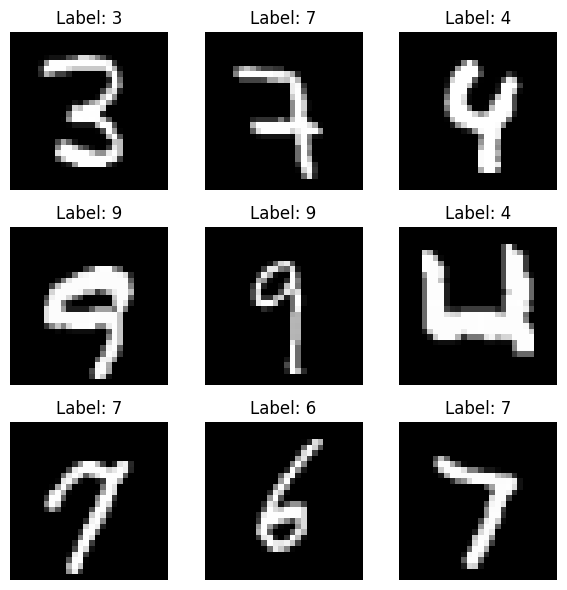

In [7]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

In [13]:
model = CNN().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [15]:
EPOCHS = 5

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS}, loss: {total_loss / len(train_loader):.4f}")

Epoch 1/5, loss: 0.1154
Epoch 2/5, loss: 0.0361
Epoch 3/5, loss: 0.0230
Epoch 4/5, loss: 0.0157
Epoch 5/5, loss: 0.0105


In [16]:
model.eval()
correct = 0
total = 0

In [17]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

In [18]:
accuracy = correct / total
accuracy

0.9905

In [19]:
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

In [20]:
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

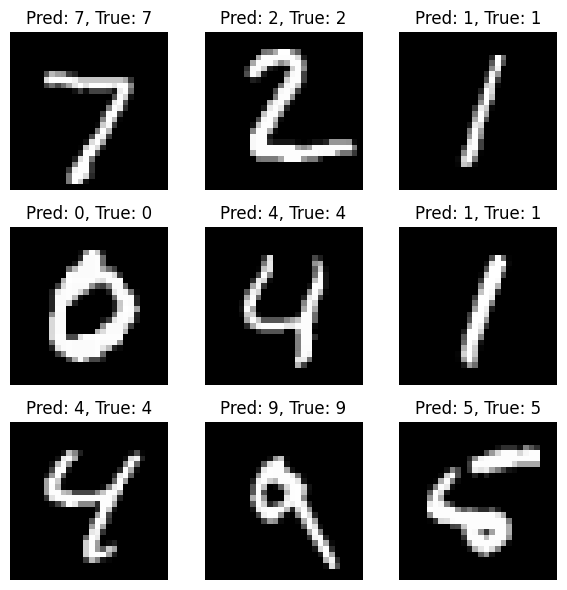

In [21]:
plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    plt.title(f"Pred: {preds[i].item()}, True: {labels[i].item()}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# OOD-датасет

In [22]:
from torchvision.datasets import FashionMNIST

In [23]:
ood_dataset = FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform  # тот же transform!
)

100%|██████████| 26.4M/26.4M [02:10<00:00, 203kB/s] 


Extracting ./data\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 393kB/s]


Extracting ./data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:10<00:00, 415kB/s]


Extracting ./data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data\FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 2.01MB/s]


Extracting ./data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\FashionMNIST\raw



In [24]:
ood_loader = DataLoader(
    ood_dataset,
    batch_size=64,
    shuffle=False
)

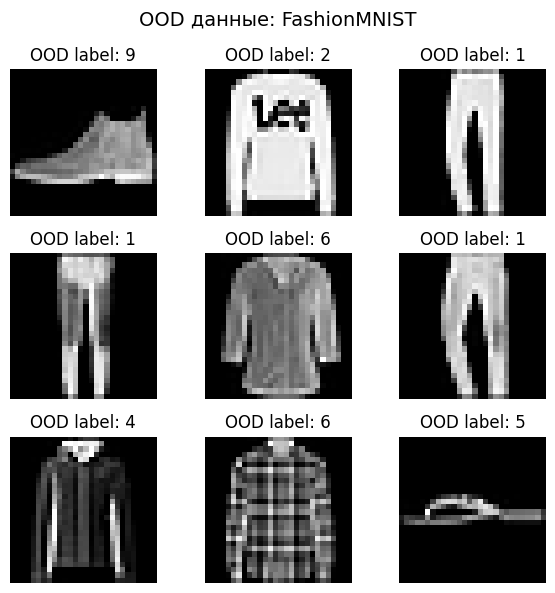

In [25]:
images, labels = next(iter(ood_loader))

plt.figure(figsize=(6, 6))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].squeeze(), cmap="gray")
    plt.title(f"OOD label: {labels[i].item()}")
    plt.axis("off")

plt.suptitle("OOD данные: FashionMNIST", fontsize=14)
plt.tight_layout()
plt.show()

In [26]:
model.eval()

all_confidences = []
all_preds = []

with torch.no_grad():
    for images, _ in ood_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1)

        max_confidence, preds = probs.max(dim=1)
        all_confidences.extend(max_confidence.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

In [27]:
id_confidences = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        logits = model(images)
        probs = torch.softmax(logits, dim=1)
        max_conf, _ = probs.max(dim=1)
        id_confidences.extend(max_conf.cpu().numpy())

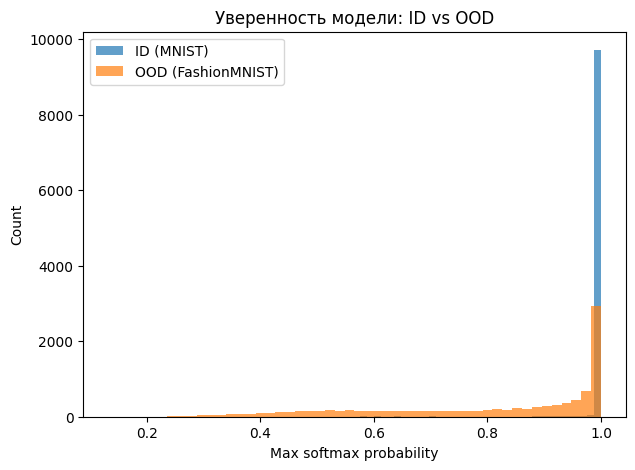

In [28]:
plt.figure(figsize=(7, 5))
plt.hist(id_confidences, bins=50, alpha=0.7, label="ID (MNIST)")
plt.hist(all_confidences, bins=50, alpha=0.7, label="OOD (FashionMNIST)")
plt.xlabel("Max softmax probability")
plt.ylabel("Count")
plt.legend()
plt.title("Уверенность модели: ID vs OOD")
plt.show()

In [29]:
y_id = np.zeros(len(id_confidences))
y_ood = np.ones(len(all_confidences))

scores = np.concatenate([
    id_confidences,
    all_confidences
])

labels = np.concatenate([
    y_id,
    y_ood
])

# MSP

In [31]:
def msp_score(logits: torch.Tensor) -> torch.Tensor:
    probs = torch.softmax(logits, dim=1)
    max_prob, _ = probs.max(dim=1)
    return 1.0 - max_prob


In [32]:
def collect_ood_scores(model, dataloader, score_fn):
    model.eval()
    scores = []

    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            logits = model(images)
            score = score_fn(logits)
            scores.extend(score.cpu().numpy())

    return np.array(scores)

In [33]:
id_msp_scores = collect_ood_scores(model, test_loader, msp_score)
ood_msp_scores = collect_ood_scores(model, ood_loader, msp_score)


In [34]:
def plot_score_distribution(id_scores, ood_scores, title):
    plt.figure(figsize=(7, 5))
    plt.hist(id_scores, bins=50, alpha=0.7, label="ID")
    plt.hist(ood_scores, bins=50, alpha=0.7, label="OOD")
    plt.xlabel("OOD score")
    plt.ylabel("Count")
    plt.legend()
    plt.title(title)
    plt.show()

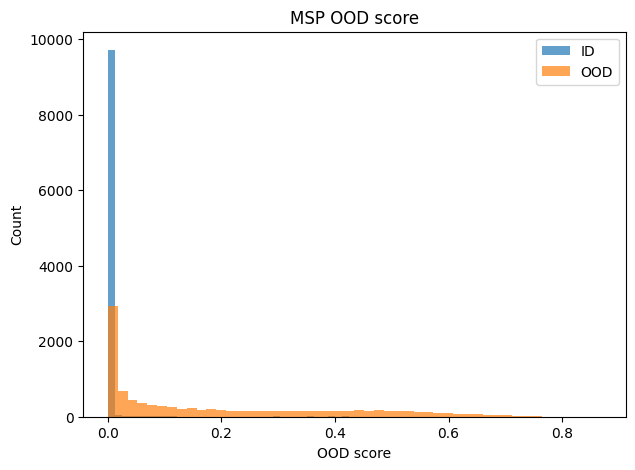

In [35]:
plot_score_distribution(id_msp_scores, ood_msp_scores, "MSP OOD score")

# Energy-based

In [36]:
def energy_score(logits: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    
    return temperature * torch.logsumexp(logits / temperature, dim=1)

In [37]:
id_energy_scores = collect_ood_scores(model, test_loader, energy_score)
ood_energy_scores = collect_ood_scores(model, ood_loader, energy_score)

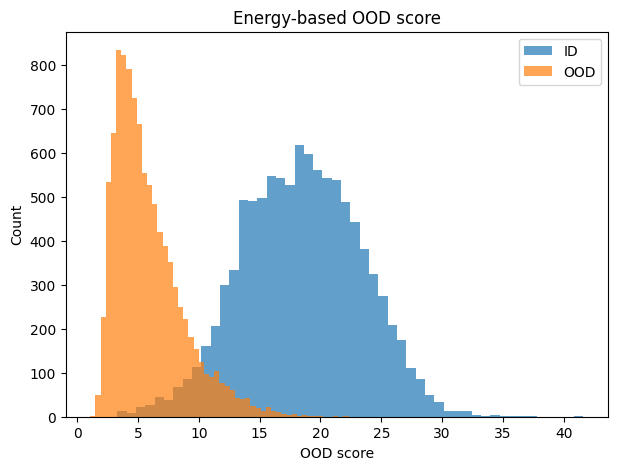

In [38]:
plot_score_distribution(id_energy_scores, ood_energy_scores, "Energy-based OOD score")

# Оценка

In [39]:
y_true = np.concatenate([
    np.zeros(len(id_msp_scores)),
    np.ones(len(ood_msp_scores))
])

In [40]:
msp_scores = np.concatenate([
    -id_msp_scores,
    -ood_msp_scores
])

In [42]:
energy_scores = np.concatenate([
    id_energy_scores,
    ood_energy_scores
])

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve

In [44]:
roc_auc_msp = roc_auc_score(y_true, msp_scores)
roc_auc_energy = roc_auc_score(y_true, energy_scores)

In [45]:
roc_auc_msp, roc_auc_energy

(0.030183134999999993, 0.016072915)

In [46]:
def fpr_at_95_tpr(y_true, scores):
    fpr, tpr, thresholds = roc_curve(y_true, scores)
    idx = np.argmin(np.abs(tpr - 0.95))
    return fpr[idx]

In [47]:
fpr95_msp = fpr_at_95_tpr(y_true, msp_scores)
fpr95_energy = fpr_at_95_tpr(y_true, energy_scores)

In [48]:
fpr95_msp, fpr95_energy

(np.float64(0.9999), np.float64(1.0))

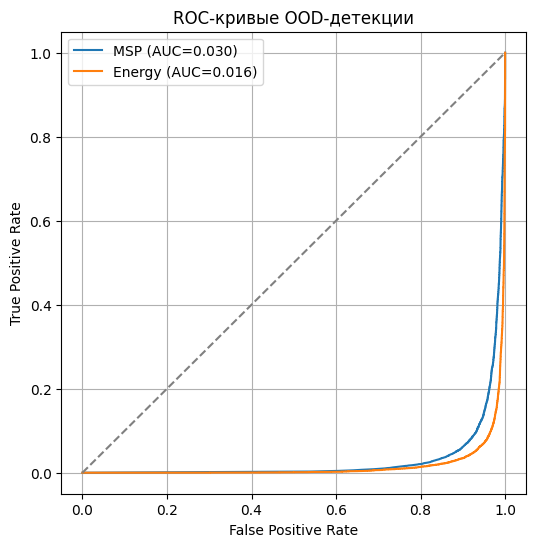

In [49]:
fpr_msp, tpr_msp, _ = roc_curve(y_true, msp_scores)
fpr_energy, tpr_energy, _ = roc_curve(y_true, energy_scores)

plt.figure(figsize=(6, 6))
plt.plot(fpr_msp, tpr_msp, label=f"MSP (AUC={roc_auc_msp:.3f})")
plt.plot(fpr_energy, tpr_energy, label=f"Energy (AUC={roc_auc_energy:.3f})")
plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые OOD-детекции")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
import pandas as pd

results = pd.DataFrame({
    "Method": ["MSP", "Energy-based"],
    "ROC-AUC": [roc_auc_msp, roc_auc_energy],
    "FPR@95TPR": [fpr95_msp, fpr95_energy]
})

In [51]:
results

,Method,ROC-AUC,FPR@95TPR
0,MSP,0.030183,0.9999
1,Energy-based,0.016073,1.0000


# OE

In [52]:
ood_train_dataset = FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

In [53]:
ood_train_loader = DataLoader(
    ood_train_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True
)

In [54]:
def oe_loss(logits):
    log_probs = torch.log_softmax(logits, dim=1)
    uniform = torch.full_like(log_probs, 1.0 / log_probs.size(1))
    return torch.mean(torch.sum(uniform * (torch.log(uniform) - log_probs), dim=1))

In [55]:
EPOCHS_OE = 5
LAMBDA_OE = 0.5

In [56]:
model.train()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [60]:
from torch.nn.functional import cross_entropy

In [61]:
for epoch in range(EPOCHS_OE):
    id_iter = iter(train_loader)
    ood_iter = iter(ood_train_loader)

    total_id_loss = 0.0
    total_ood_loss = 0.0

    for _ in range(min(len(train_loader), len(ood_train_loader))):
        id_images, id_labels = next(id_iter)
        ood_images, _ = next(ood_iter)

        id_images = id_images.to(device)
        id_labels = id_labels.to(device)
        ood_images = ood_images.to(device)

        optimizer.zero_grad()

        id_logits = model(id_images)
        loss_id = cross_entropy(id_logits, id_labels)

        ood_logits = model(ood_images)
        loss_ood = oe_loss(ood_logits)

        loss = loss_id + LAMBDA_OE * loss_ood
        loss.backward()
        optimizer.step()

        total_id_loss += loss_id.item()
        total_ood_loss += loss_ood.item()

    print(
        f"Epoch {epoch+1}/{EPOCHS_OE} | "
        f"ID loss: {total_id_loss:.3f} | "
        f"OOD loss: {total_ood_loss:.3f}"
    )

Epoch 1/5 | ID loss: 15.108 | OOD loss: 20.567
Epoch 2/5 | ID loss: 6.057 | OOD loss: 1.018
Epoch 3/5 | ID loss: 4.192 | OOD loss: 0.625
Epoch 4/5 | ID loss: 5.926 | OOD loss: 0.549
Epoch 5/5 | ID loss: 4.254 | OOD loss: 0.397


In [62]:
model.eval()
correct = 0
total = 0

In [63]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        logits = model(images)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

In [64]:
id_accuracy_after_oe = correct / total
id_accuracy_after_oe

0.991

# Повтор OOD

In [65]:
def msp_score(model, loader):
    model.eval()
    scores = []

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            probs = torch.softmax(logits, dim=1)
            max_prob, _ = probs.max(dim=1)
            scores.extend(max_prob.cpu().numpy())

    return np.array(scores)

In [66]:
def energy_score(model, loader, T=1.0):
    model.eval()
    scores = []

    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)
            logits = model(x)
            energy = -T * torch.logsumexp(logits / T, dim=1)
            scores.extend(energy.cpu().numpy())

    return np.array(scores)

In [67]:
id_msp = msp_score(model, test_loader)
id_energy = energy_score(model, test_loader)

In [68]:
ood_msp = msp_score(model, ood_loader)
ood_energy = energy_score(model, ood_loader)

In [69]:
def evaluate_ood(id_scores, ood_scores, invert=False):
    y_true = np.concatenate([
        np.zeros(len(id_scores)),
        np.ones(len(ood_scores))
    ])

    scores = np.concatenate([id_scores, ood_scores])
    if invert:
        scores = -scores

    roc_auc = roc_auc_score(y_true, scores)
    fpr95 = fpr_at_95_tpr(y_true, scores)

    return roc_auc, fpr95

In [70]:
results_after = []

In [71]:
roc, fpr = evaluate_ood(id_msp, ood_msp, invert=True)
results_after.append(("MSP", roc, fpr))

In [72]:
roc, fpr = evaluate_ood(id_energy, ood_energy)
results_after.append(("Energy", roc, fpr))

In [73]:
df_after = pd.DataFrame(results_after, columns=["Method", "ROC-AUC", "FPR@95TPR"])
df_after

,Method,ROC-AUC,FPR@95TPR
0,MSP,1.0000,0.0000
1,Energy,0.9996,0.0004


In [74]:
results["Stage"] = "Before OE"
df_after["Stage"] = "After OE"


In [75]:
comparison = pd.concat([results, df_after])
comparison

,Method,ROC-AUC,FPR@95TPR,Stage
0,MSP,0.030183,0.9999,Before OE
1,Energy-based,0.016073,1.0000,Before OE
0,MSP,1.000000,0.0000,After OE
1,Energy,0.999600,0.0004,After OE
